# Julia: First Steps

For this tutorial, we're going to fit a Gaussian Process (GP) model to a simulated dataset with quasiperiodic oscillations. We're also going to leave a gap in the simulated data and we'll use the GP model to predict what we would have observed for those "missing" datapoints.

To start, here's some code to simulate the dataset:

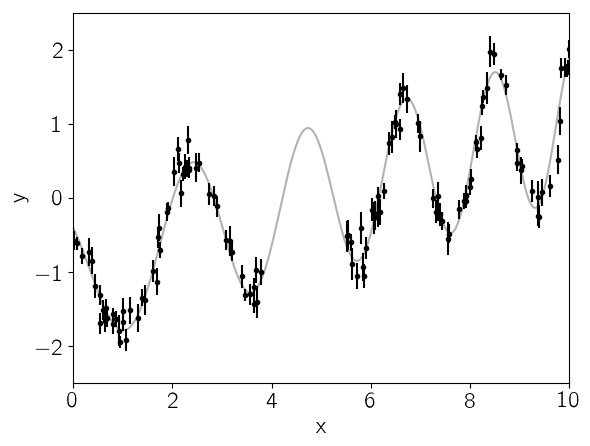

In [1]:
import Optim
import PyPlot
import celerite

srand(42)

# The input coordinates must be sorted
t = sort(cat(1, 3.8 * rand(57), 5.5 + 4.5 * rand(68)))
yerr = 0.08 + (0.22-0.08)*rand(length(t))
y = 0.2*(t-5.0) + sin(3.0*t + 0.1*(t-5.0).^2) + yerr .* randn(length(t))

true_t = linspace(0, 10, 5000)
true_y = 0.2*(true_t-5) + sin(3*true_t + 0.1*(true_t-5).^2)

PyPlot.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
PyPlot.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.xlim(0, 10)
PyPlot.ylim(-2.5, 2.5);

This plot shows the simulated data as black points with error bars and the true function is shown as a gray line.

Now let's build the `celerite` model that we'll use to fit the data. We can see that there's some roughly periodic signal in the data as well as a longer term trend. To capture these two features, we will model this as a mixture of two stochastically driven simple harmonic oscillators with the power spectrum:

$$
S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_1\,{\omega_1}^4}{(\omega^2 - {\omega_1}^2)^2 + 2\,{\omega_1}^2\,\omega^2}
+ \sqrt{\frac{2}{\pi}}\frac{S_2\,{\omega_2}^4}{(\omega^2 - {\omega_2}^2)^2 + {\omega_2}^2\,\omega^2/Q^2}
$$

This model has 5 free parameters ($S_1$, $\omega_1$, $S_2$, $\omega_2$, and $Q$) and they must all be positive. In `celerite`, this is how you would build this model, choosing more or less arbitrary initial values for the parameters.

In [2]:
Q = 1.0 / sqrt(2.0)
w0 = 3.0
S0 = var(y) / (w0 * Q)
kernel = celerite.SHOTerm(log(S0), log(Q), log(w0))

# A periodic component
Q = 1.0
w0 = 3.0
S0 = var(y) / (w0 * Q)
kernel = kernel + celerite.SHOTerm(log(S0), log(Q), log(w0))

celerite.TermSum((celerite.SHOTerm(-0.7432145976901582,-0.34657359027997275,1.0986122886681096),celerite.SHOTerm(-1.089788187970131,0.0,1.0986122886681096)))

Then we wrap this kernel in a `Celerite` type that can be used for computing the likelihood function.

In [3]:
gp = celerite.Celerite(kernel)
celerite.compute!(gp, t, yerr)
celerite.log_likelihood(gp, y)

-15.225587873319103

We can look at the prediction from our initial guess at the model and see how it compares to the true relation:

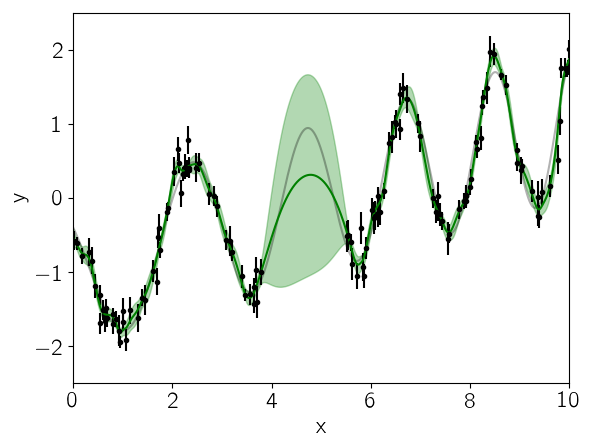

In [4]:
mu, variance = celerite.predict(gp, y, true_t, return_var=true)
sigma = sqrt(variance)

PyPlot.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
PyPlot.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
PyPlot.plot(true_t, mu, "g")
PyPlot.fill_between(true_t, mu+sigma, mu-sigma, color="g", alpha=0.3)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.xlim(0, 10)
PyPlot.ylim(-2.5, 2.5);

Now we'll use the `L-BFGS` non-linear optimization routine from the `Optim` package to find the maximum likelihood parameters for this model.

In [5]:
vector = celerite.get_parameter_vector(gp.kernel)
mask = ones(Bool, length(vector))
mask[2] = false  # Don't fit for the first Q
function nll(params)
    vector[mask] = params
    celerite.set_parameter_vector!(gp.kernel, vector)
    celerite.compute!(gp, t, yerr)
    return -celerite.log_likelihood(gp, y)
end;

In [6]:
result = Optim.optimize(nll, vector[mask], Optim.LBFGS())
result

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.7432145976901582,1.0986122886681096, ...]
 * Minimizer: [3.0068763552021567,-2.005554052352084, ...]
 * Minimum: -3.042655e+00
 * Iterations: 21
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 86
 * Gradient Calls: 86

The maximum likelihood parameters are the following:

In [7]:
vector[mask] = Optim.minimizer(result)
vector

6-element Array{Float64,1}:
  3.00688 
 -0.346574
 -2.00555 
 -3.69141 
  1.94525 
  1.13941 

Finally, let's see what the model predicts for the underlying function. A GP model can predict the (Gaussian) conditional (on the observed data) distribution for new observations. Let's do that on a fine grid:

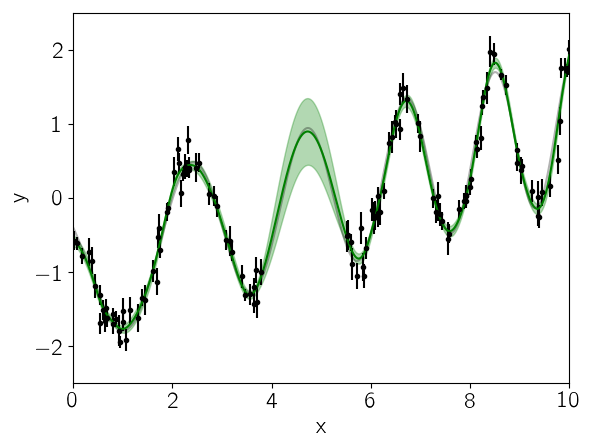

In [8]:
celerite.set_parameter_vector!(gp.kernel, vector)

mu, variance = celerite.predict(gp, y, true_t, return_var=true)
sigma = sqrt(variance)

PyPlot.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
PyPlot.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
PyPlot.plot(true_t, mu, "g")
PyPlot.fill_between(true_t, mu+sigma, mu-sigma, color="g", alpha=0.3)
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.xlim(0, 10)
PyPlot.ylim(-2.5, 2.5);

In this figure, the 1-sigma prediction is shown as a green band and the mean prediction is indicated by a solid green line. Comparing this to the true underlying function (shown as a gray line), we see that the prediction is consistent with the truth at all times and the the uncertainty in the region of missing data increases as expected.

As the last figure, let's look at the maximum likelihood power spectrum of the model. The following figure shows the model power spectrum as a solid line and the dashed lines show the contributions from the two components.

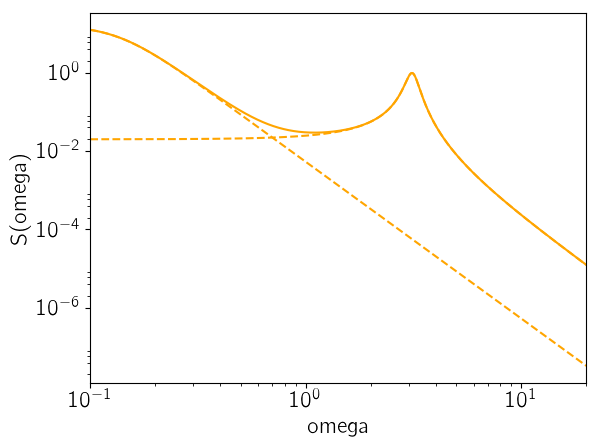

In [11]:
omega = exp(linspace(log(0.1), log(20), 5000))
psd = celerite.get_psd(gp.kernel, omega)

for term in gp.kernel.terms
    PyPlot.plot(omega, celerite.get_psd(term, omega), "--", color="orange")
end
PyPlot.plot(omega, psd, color="orange")

PyPlot.yscale("log")
PyPlot.xscale("log")
PyPlot.xlim(omega[1], omega[end])
PyPlot.xlabel("omega")
PyPlot.ylabel("S(omega)");